In [1]:
import os
import torch
import torchsig

import numpy as np
import torch.nn.functional as F
import torchsig.transforms as ST

from datetime import datetime
from matplotlib import pyplot as plt
from models import CustomNetwork
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
from sklearn.metrics import classification_report
from torch import optim
from torch.utils.data import DataLoader
from torchsig.datasets.sig53 import Sig53
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    TargetSNR,
    ComplexTo2D,
)
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from tqdm import tqdm
from typing import List


In [2]:

dataset_path = "./dev_data/torchsig_test/gamutrf-wifi-and-anom-bladerf"
num_iq_samples = 1024
idx_to_class = {
  0: 'anom_wifi',
  1: 'mini2_telem',
  2: 'mini2_video',
  3: 'wifi6',
  4: 'wifi',
  5: 'fhss_css'
}

In [3]:
transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    class_list = list(idx_to_class.values()),
    transform = transform,
    only_first_samples=True,
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

Class List: ['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']
len(dataset)=252031
{'anom_wifi': 129335, 'mini2_telem': 0, 'mini2_video': 0, 'wifi6': 0, 'wifi': 122696, 'fhss_css': 0}


In [4]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=180,
    num_workers=16,
    shuffle=False,
    drop_last=True,
)

In [11]:
model = torch.jit.load('weights/checkpoint-v16_torchscript.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = CustomNetwork(model, dataloader)

example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

In [12]:
# Infer results over validation set
num_test_examples = len(dataset)
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))
y_true_list = []
y_preds_list = []
with torch.no_grad():
    example_model.eval()
    for data, label in tqdm(dataloader):
        # Infer
        data = data.float()

        data = data.cuda() if torch.cuda.is_available() else data
        pred_tmp = example_model.predict(data)
        pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp

        y_preds_list.extend(np.argmax(pred_tmp, axis=1).tolist())
        y_true_list.extend(label.tolist())
        
y_preds = y_preds_list
y_true = y_true_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [01:36<00:00, 14.49it/s]


/home/ltindall/.pyenv/versions/3.10.9/envs/rfml-dev/lib/python3.10/site-packages/torchsig/utils/cm_plotter.py:31: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


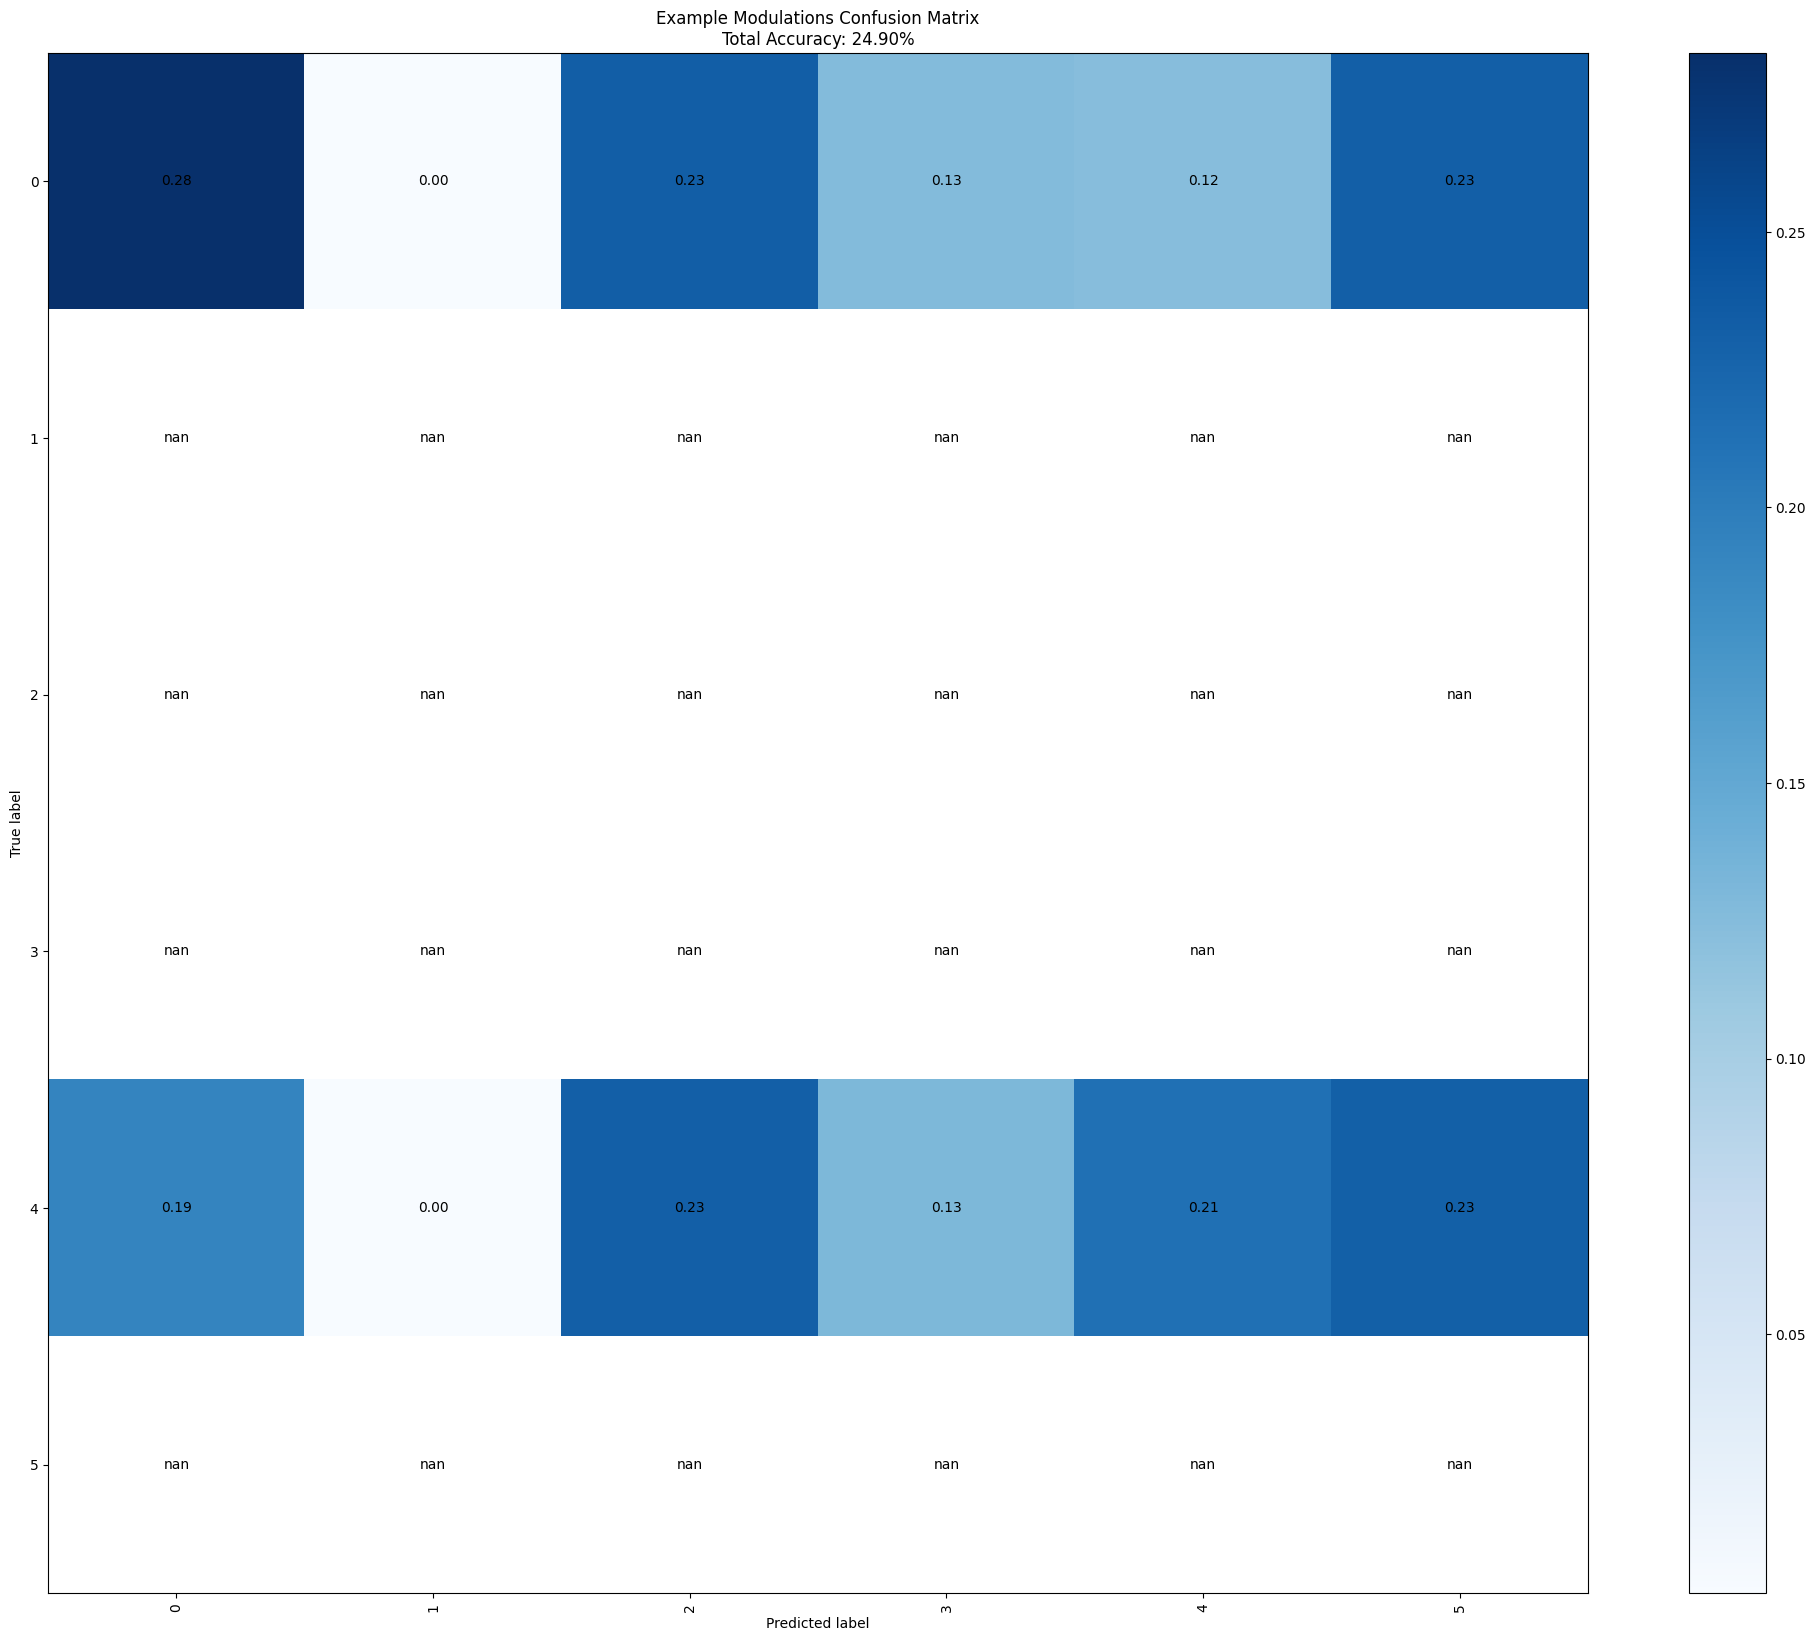

In [13]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=np.unique(np.concatenate((np.arange(len(dataset.class_list)),np.unique(y_preds)))),
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=True,
    rotate_x_text=90,
    figsize=(26,20),
)
plt.show()